In [269]:
# import libraries
import warnings
import pandas as pd
import numpy as np
from numpy import mean, std
import seaborn as sns
import plotly.express as px
from scipy.io.arff import loadarff
from matplotlib import pyplot as plt
from datetime import datetime as dt
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, learning_curve
#from mlxtend.evaluate import bias_variance_decomp
warnings.filterwarnings('ignore')

In [270]:
# load dataset
df0 = pd.read_csv('./data.csv')
df0.head()

,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,21.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Preparation

### Build the data quality report

In [271]:
# Data Type Normalization
df0 = df0.convert_dtypes()
# General infomation
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    Int64  
 1   diagnosis                569 non-null    string 
 2   Radius_mean              569 non-null    Float64
 3   Texture_mean             569 non-null    Float64
 4   perimeter_mean           569 non-null    Float64
 5   area_mean                569 non-null    Float64
 6   smoothness_mean          569 non-null    Float64
 7   compactness_mean         569 non-null    Float64
 8   concavity_mean           569 non-null    Float64
 9   concave points_mean      569 non-null    Float64
 10  symmetry_mean            569 non-null    Float64
 11  fractal_dimension_mean   569 non-null    Float64
 12  radius_se                569 non-null    Float64
 13  texture_se               569 non-null    Float64
 14  perimeter_se             5

#### Continous feature report

In [272]:
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

    # generate the continuous data quility report
build_continuous_features_report(df0.iloc[:,1:])

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Radius_mean,569,0.0,456,6.981000,11.7,14.127292,13.370000,15.78,28.11000,3.524049
Texture_mean,569,0.0,479,9.710000,16.17,19.296678,18.870000,21.8,39.28000,4.301816
perimeter_mean,569,0.0,522,43.790000,75.17,91.969033,86.240000,104.1,188.50000,24.298981
area_mean,569,0.0,539,143.500000,420.3,654.889104,551.100000,782.7,2501.00000,351.914129
smoothness_mean,569,0.0,474,0.052630,0.08637,0.096360,0.095870,0.1053,0.16340,0.014064
compactness_mean,569,0.0,537,0.019380,0.06492,0.104341,0.092630,0.1304,0.34540,0.052813
concavity_mean,569,0.0,537,0.000000,0.02956,0.088799,0.061540,0.1307,0.42680,0.079720
concave points_mean,569,0.0,542,0.000000,0.02031,0.048919,0.033500,0.074,0.20120,0.038803
symmetry_mean,569,0.0,432,0.106000,0.1619,0.181162,0.179200,0.1957,0.30400,0.027414
fractal_dimension_mean,569,0.0,499,0.049960,0.0577,0.062798,0.061540,0.06612,0.09744,0.007060


In [273]:
# generate the continuous data quility report
df0.iloc[:,1:].describe()

,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.296678,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301816,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.870000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Categorical features report

In [274]:
def build_categorical_features_report(data_df):

    """Build tabular report for categorical features"""

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list())

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]

    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df


# generate the category data quility report
build_categorical_features_report(df0)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
diagnosis,569,0.0,2,NaN,357,62.741652,NaN,212,37.258348


In [275]:
# generate the category data quility report
df0.describe(exclude=['number'])

,diagnosis
count,569
unique,2
top,B
freq,357


In [276]:
df = df0.iloc[:,1:12]
df.head()

,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871
1,M,20.57,21.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744
4,M,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883


#### Feature visualization

##### Continuous feature - Histograms

In [277]:
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 15

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

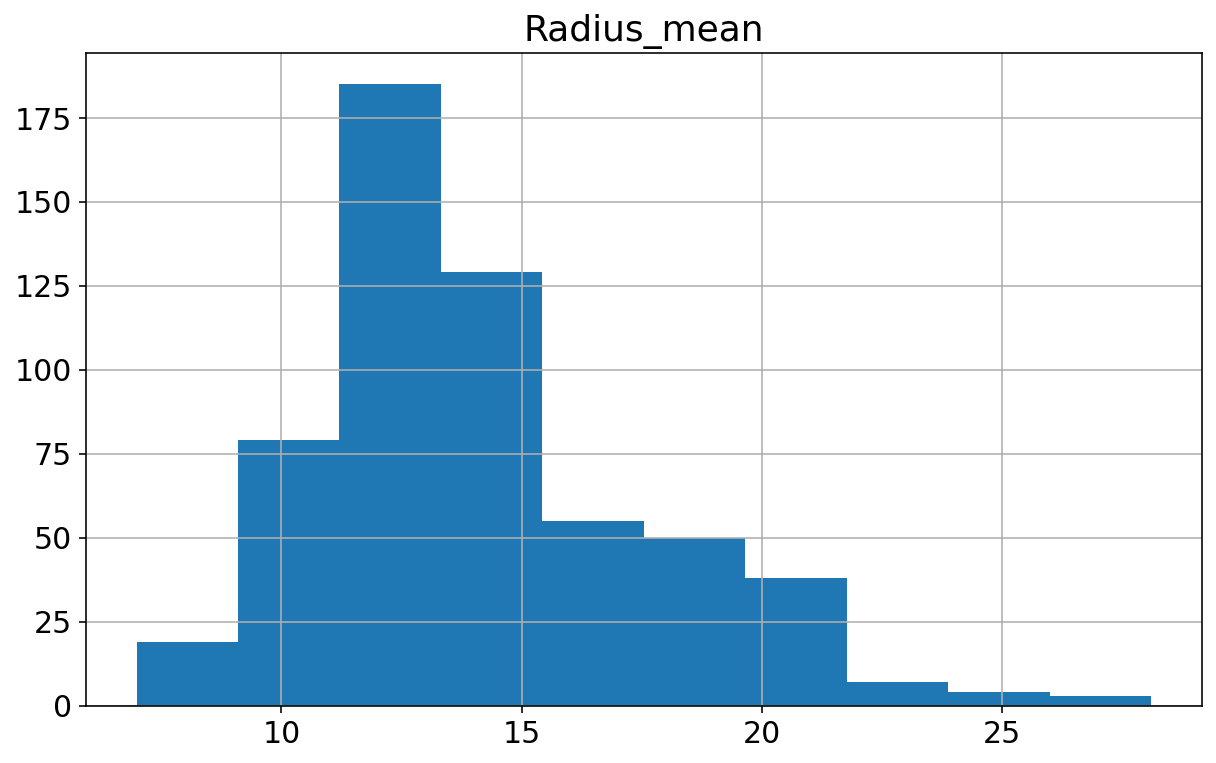

In [278]:
df.hist(column=['Radius_mean']);

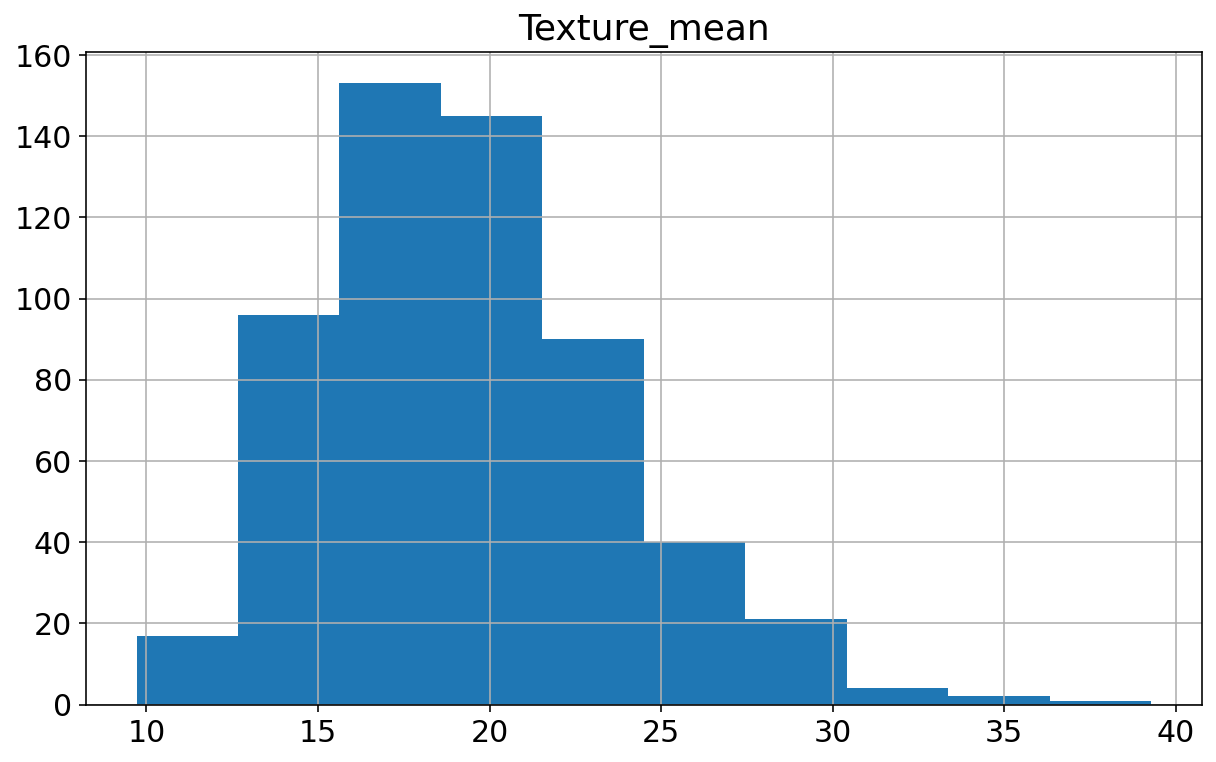

In [279]:
df.hist(column=['Texture_mean']);

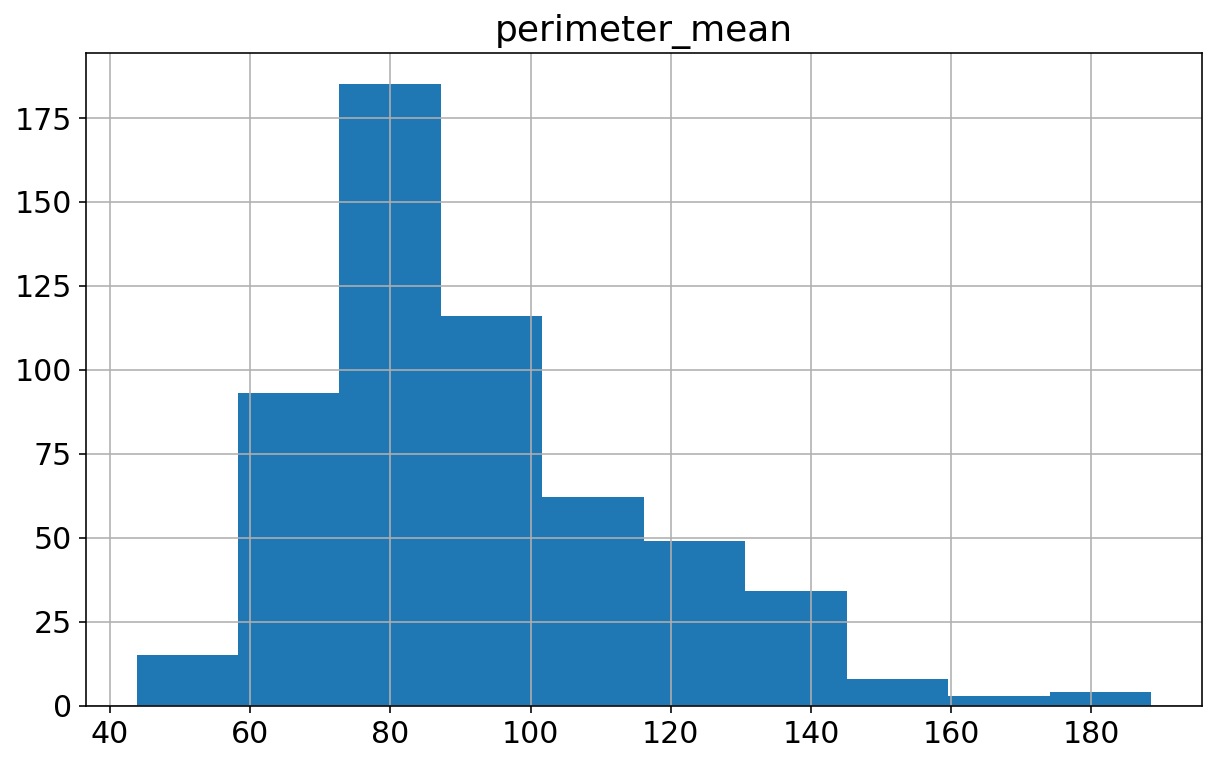

In [280]:
df.hist(column=['perimeter_mean']);

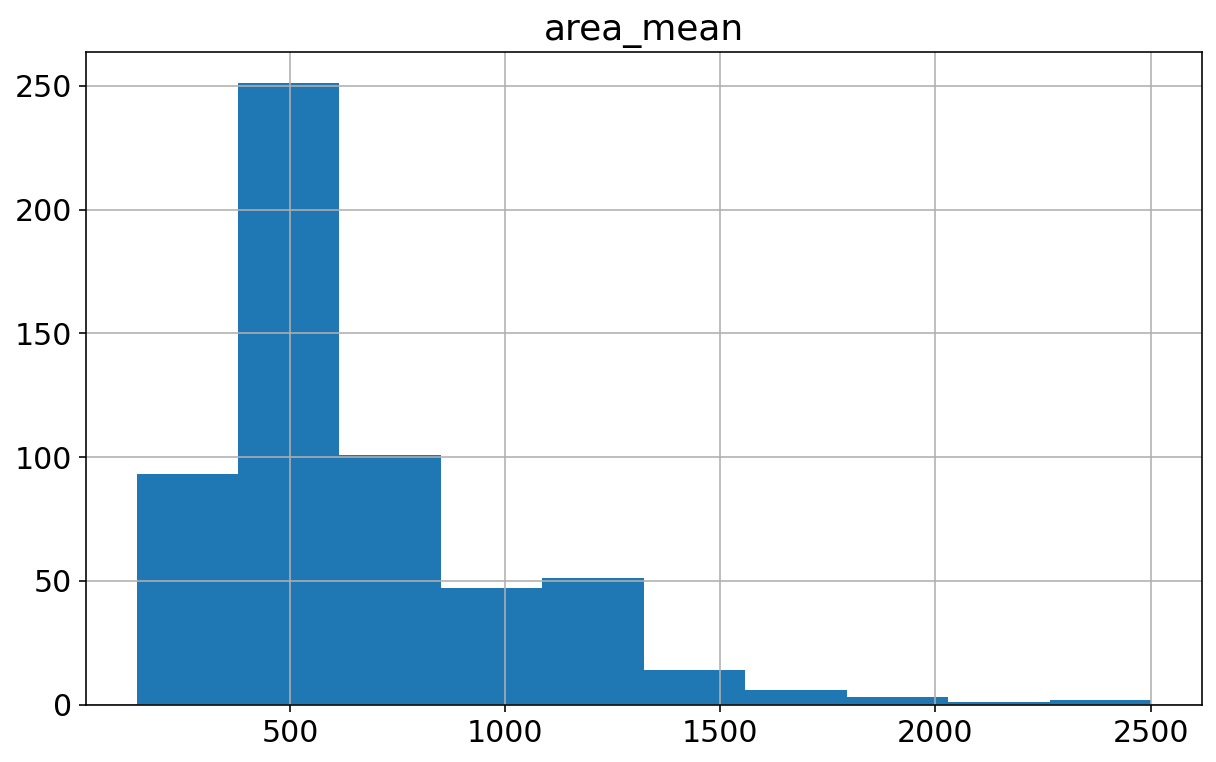

In [281]:
df.hist(column=['area_mean']);

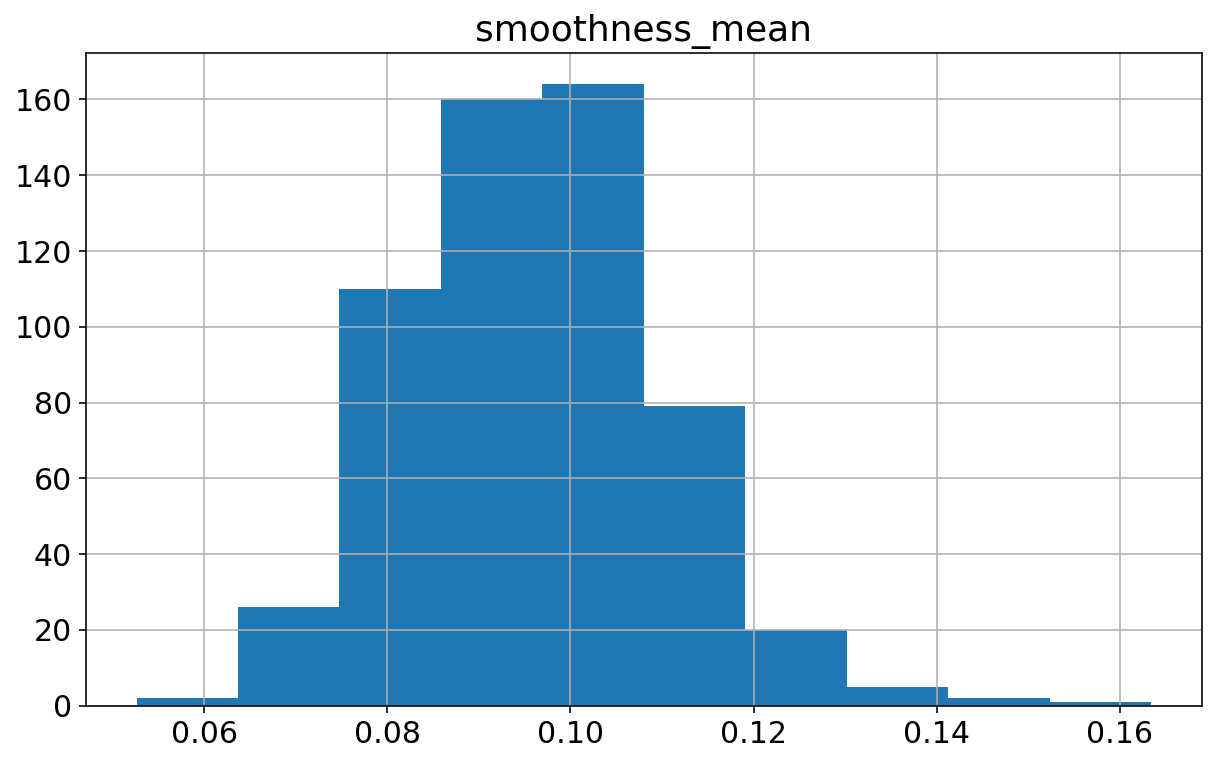

In [282]:
df.hist(column=['smoothness_mean']);

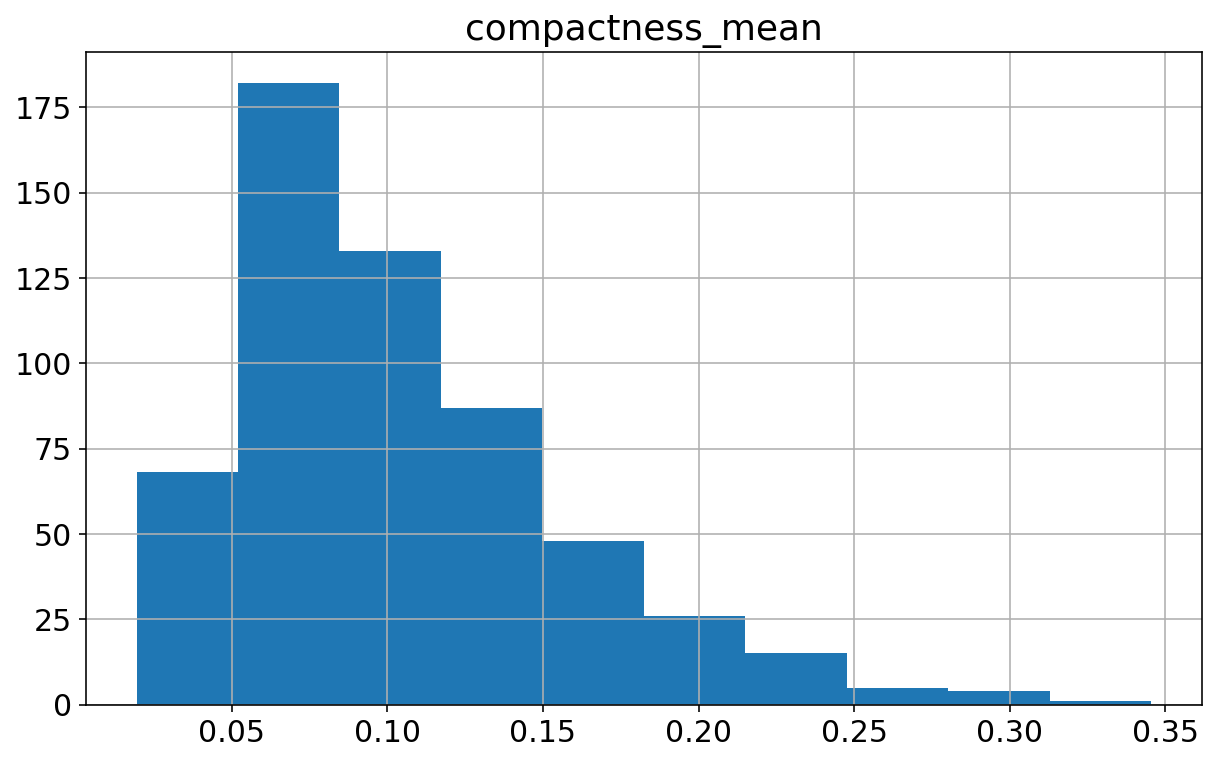

In [283]:
df.hist(column=['compactness_mean']);

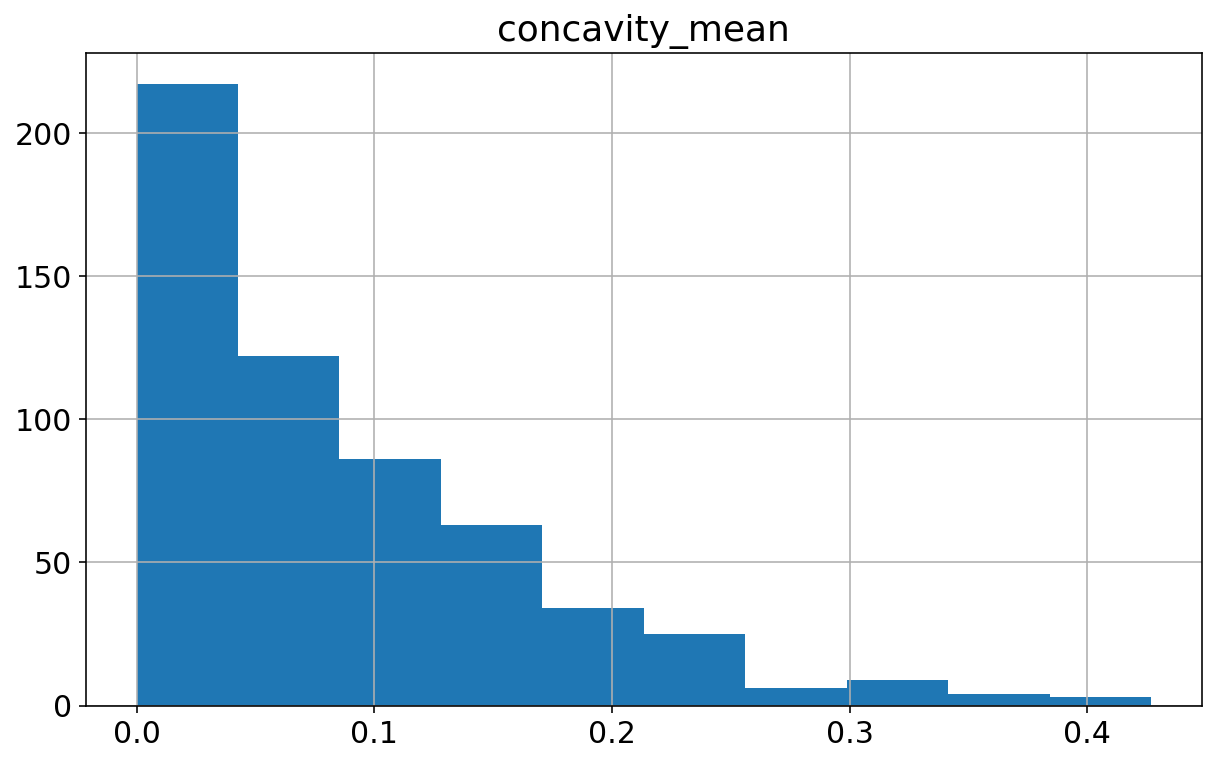

In [284]:
df.hist(column=['concavity_mean']);

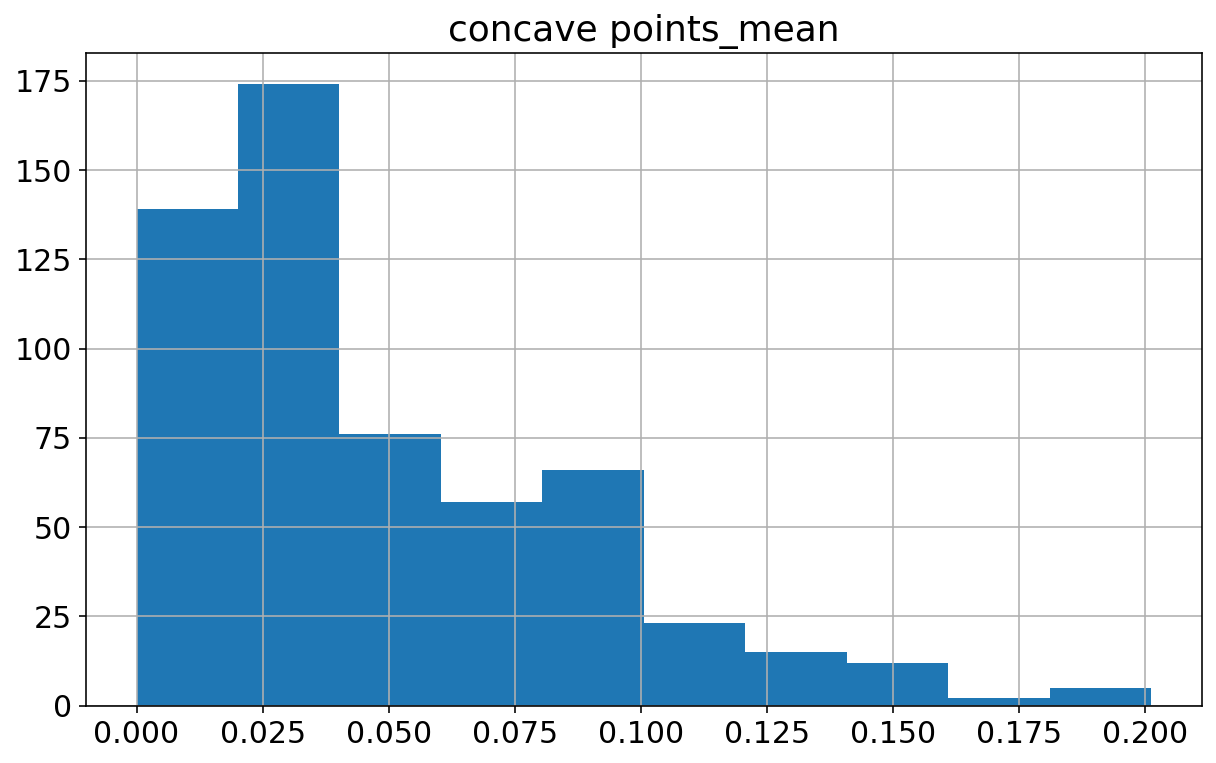

In [285]:
df.hist(column=['concave points_mean']);

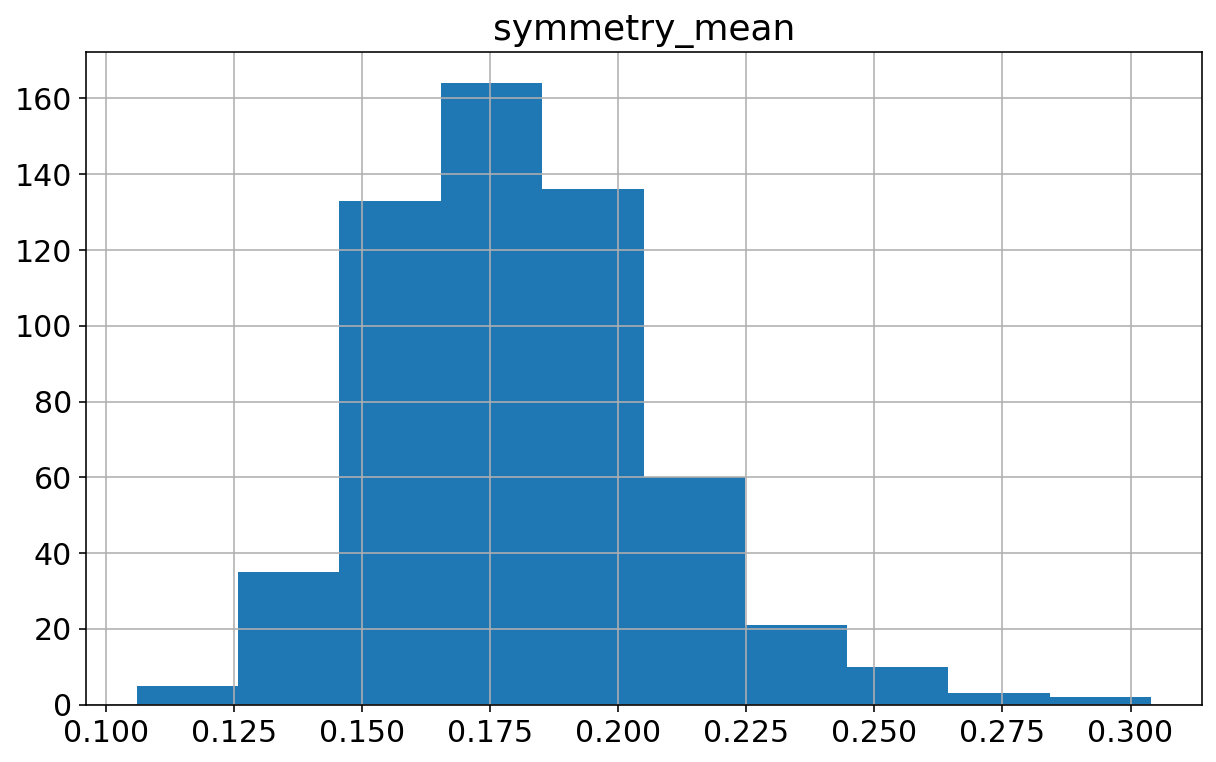

In [286]:
df.hist(column=['symmetry_mean']);

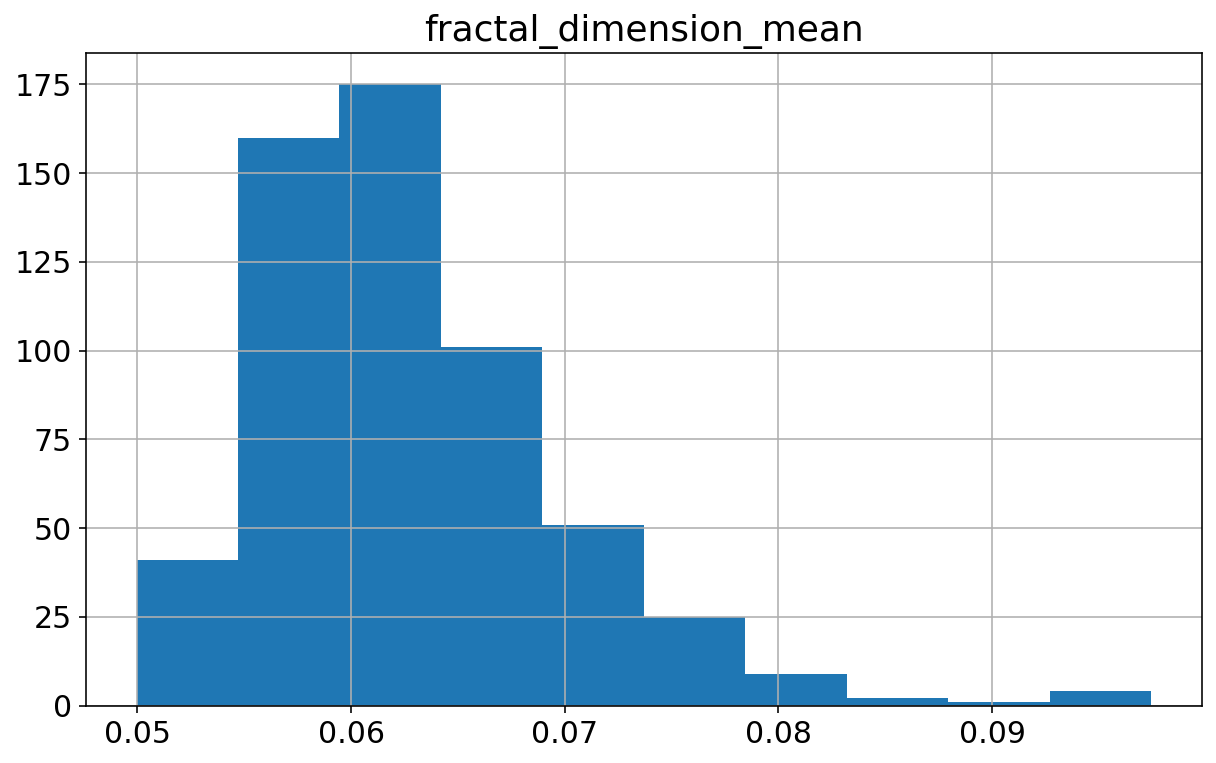

In [287]:
df.hist(column=['fractal_dimension_mean']);

##### Categorical feature - Bar Plots

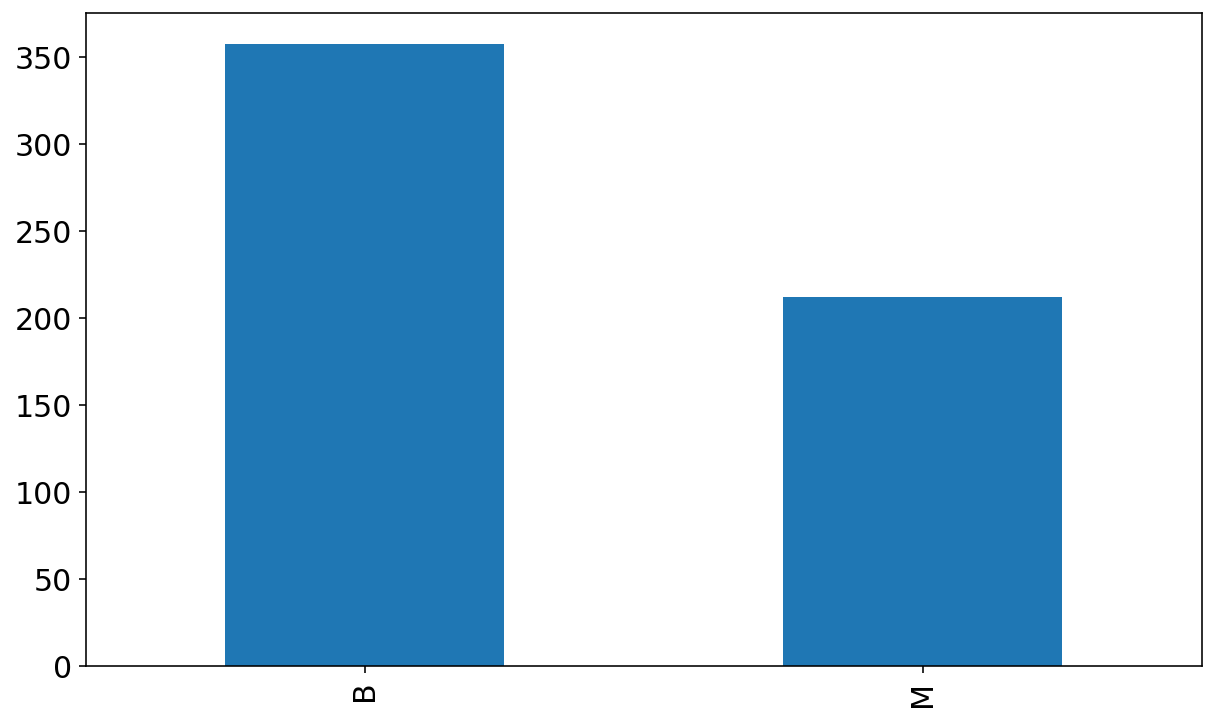

In [288]:
df['diagnosis'].value_counts().plot.bar();

### Data quality issues

#### Modify the target feature.

In [289]:
#Malignant value is set to 0, benign value is set to 1
df['diagnosis'].replace(["M", "B"], ["0", "1"], inplace=True)
df['diagnosis'] = df['diagnosis'].astype('int')

#### Missing values

In [290]:
# Dropping null values in rows
df.dropna()

,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871
1,0,20.57,21.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,0,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999
3,0,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744
4,0,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...
564,0,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623
565,0,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533
566,0,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648
567,0,20.6,29.33,140.1,1265.0,0.1178,0.277,0.3514,0.152,0.2397,0.07016


In [291]:
correlation_matrix=df.corr()
print(correlation_matrix)

                        diagnosis  Radius_mean  Texture_mean  perimeter_mean  \
diagnosis                1.000000    -0.730029     -0.417232       -0.742636   
Radius_mean             -0.730029     1.000000      0.326716        0.997855   
Texture_mean            -0.417232     0.326716      1.000000        0.332231   
perimeter_mean          -0.742636     0.997855      0.332231        1.000000   
area_mean               -0.708984     0.987357      0.324149        0.986507   
smoothness_mean         -0.358560     0.170581     -0.024737        0.207278   
compactness_mean        -0.596534     0.506124      0.235863        0.556936   
concavity_mean          -0.696360     0.676764      0.302324        0.716136   
concave points_mean     -0.776614     0.822529      0.294307        0.850977   
symmetry_mean           -0.330499     0.147741      0.071390        0.183027   
fractal_dimension_mean   0.012838    -0.311631     -0.077844       -0.261477   

                        area_mean  smoo

#### PCA

In [292]:
#PCA
df2=df0.iloc[:,1:12]
# Separating out the features
x = df2.iloc[:,1:12]
# Separating out the target
y = df2.loc[:,['diagnosis']]
# Standardizing the features
X = StandardScaler().fit_transform(x)

In [293]:
X = pd.DataFrame(X,columns=['Radius_mean','Texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,5.221448,3.212226
1,1.872559,-2.676771
2,3.969548,-0.547765
3,3.594393,6.904804
4,3.150314,-1.352240
...,...,...
564,4.437050,-2.018007
565,2.876037,-2.396976
566,0.650928,-2.045249
567,6.905714,1.215454


In [294]:
finalDf = pd.concat([principalDf, df[['diagnosis']]], axis = 1)
finalDf

,principal component 1,principal component 2,diagnosis
0,5.221448,3.212226,0
1,1.872559,-2.676771,0
2,3.969548,-0.547765,0
3,3.594393,6.904804,0
4,3.150314,-1.352240,0
...,...,...,...
564,4.437050,-2.018007,0
565,2.876037,-2.396976,0
566,0.650928,-2.045249,0
567,6.905714,1.215454,0


array([0.54794517, 0.2519959 ])

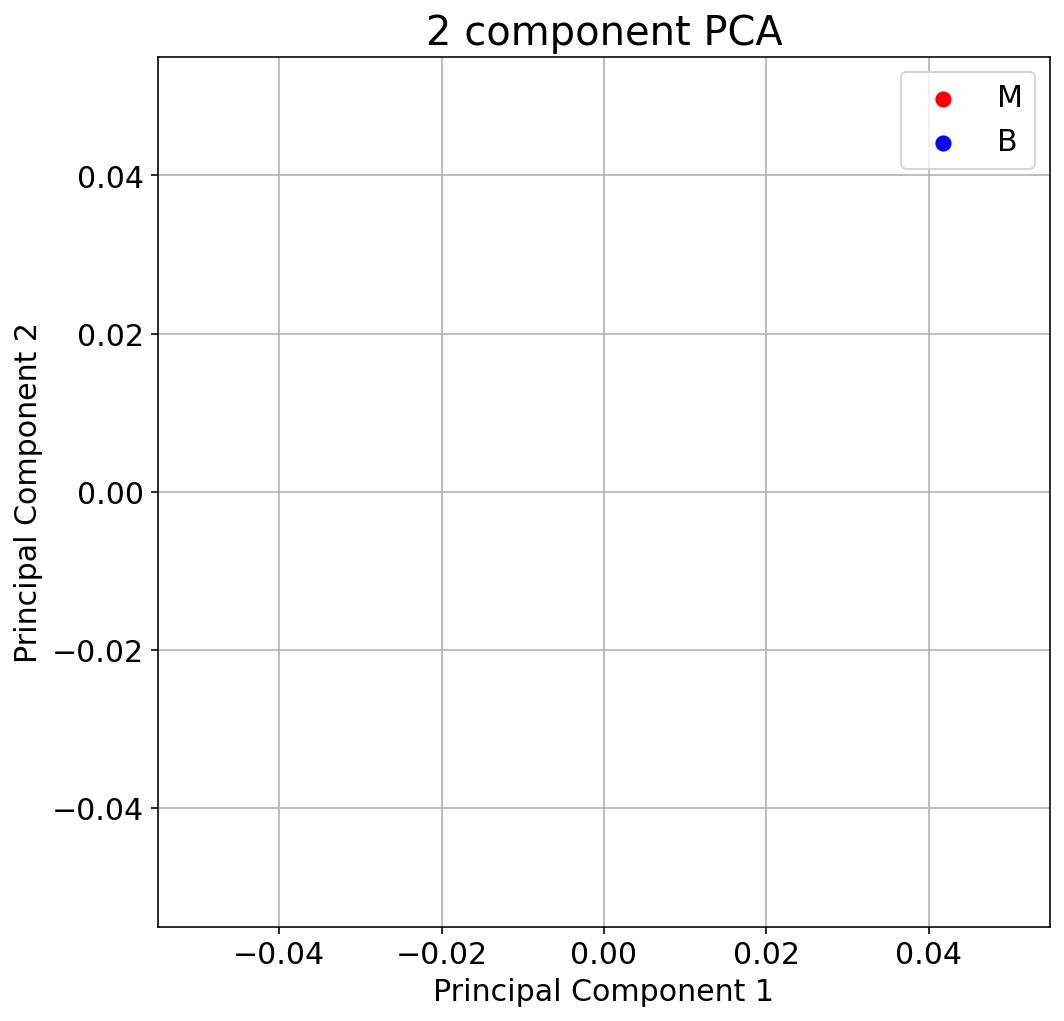

In [295]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['M', 'B']
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
pca.explained_variance_ratio_

## Summary

In [296]:
import statsmodels.api as sm

y = df['diagnosis']
print(type(y))
def get_stats():
    results = sm.OLS(y, X).fit()
    print(results.summary())
get_stats()

<class 'pandas.core.series.Series'>
                                 OLS Regression Results                                
Dep. Variable:              diagnosis   R-squared (uncentered):                   0.255
Model:                            OLS   Adj. R-squared (uncentered):              0.241
Method:                 Least Squares   F-statistic:                              19.08
Date:                Mon, 05 Dec 2022   Prob (F-statistic):                    2.57e-30
Time:                        03:23:58   Log-Likelihood:                         -591.20
No. Observations:                 569   AIC:                                      1202.
Df Residuals:                     559   BIC:                                      1246.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      

In [297]:
finalDf.iloc[:,0]

0      5.221448
1      1.872559
2      3.969548
3      3.594393
4      3.150314
         ...   
564    4.437050
565    2.876037
566    0.650928
567    6.905714
568   -3.969797
Name: principal component 1, Length: 569, dtype: float64

There are no missing values in the dataset.

#### Irregular cardinality

In [298]:
# Get unique values of each column in the dataframe
uniqueValues = df.nunique()
print(len(df))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print((uniqueValues))

569
diagnosis                   2
Radius_mean               456
Texture_mean              479
perimeter_mean            522
area_mean                 539
smoothness_mean           474
compactness_mean          537
concavity_mean            537
concave points_mean       542
symmetry_mean             432
fractal_dimension_mean    499
dtype: int64


In [299]:
df

,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871
1,0,20.57,21.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,0,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999
3,0,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744
4,0,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...
564,0,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623
565,0,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533
566,0,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648
567,0,20.6,29.33,140.1,1265.0,0.1178,0.277,0.3514,0.152,0.2397,0.07016


As we can see, the following common issues do not appear in the dataframe:

* Features with a cardinality of 1
* Too high cardinality for categorical features
* Too low cardinality for continous features

Hence we do not need to drop any column

#### Boxplot for each variables
#### Radius

<AxesSubplot:>

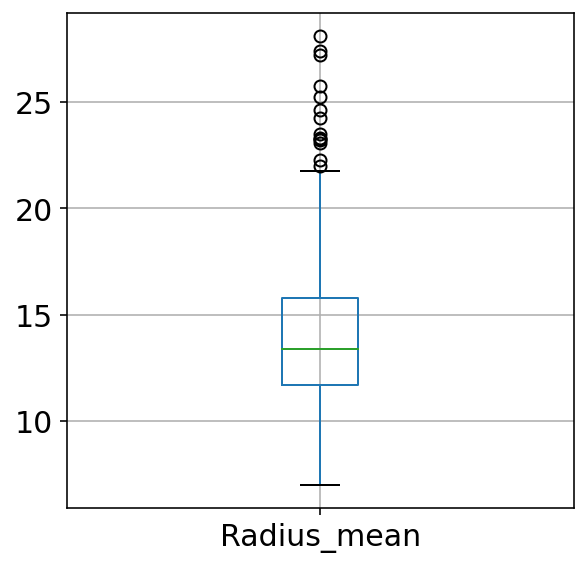

In [300]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('Radius_mean')




#### Texture

<AxesSubplot:>

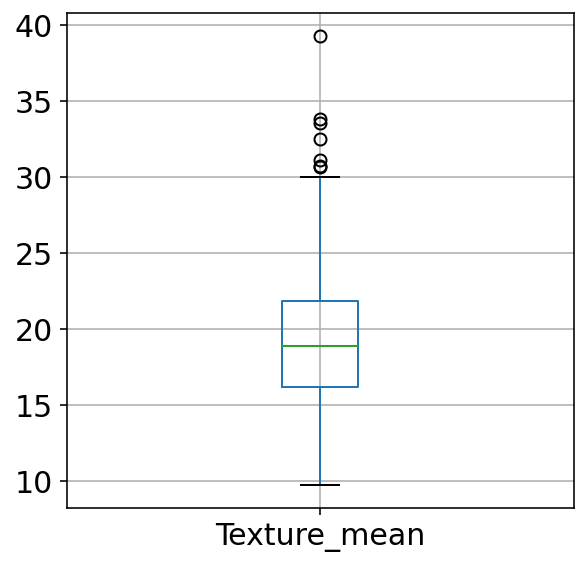

In [301]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('Texture_mean')
# plt.subplot(2,2,2)
# df.boxplot('texture_se')
# plt.subplot(2,2,3)
# df.boxplot('texture_worst')

#### Perimeter

<AxesSubplot:>

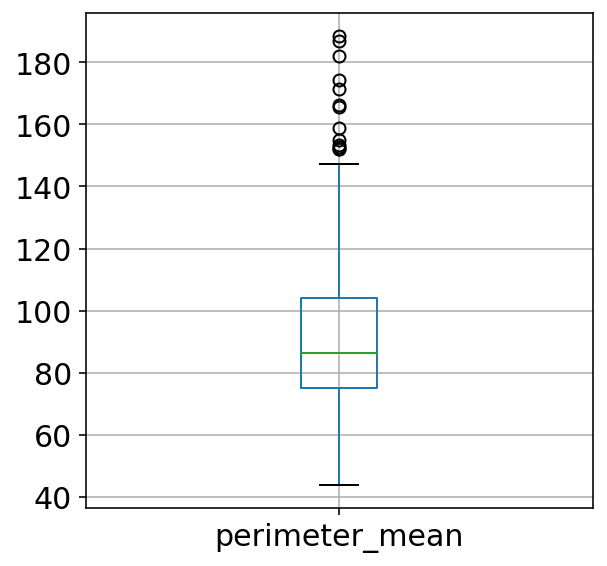

In [302]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('perimeter_mean')
# plt.subplot(2,2,2)
# df.boxplot('perimeter_se')
# plt.subplot(2,2,3)
# df.boxplot('perimeter_worst')

#### Area

<AxesSubplot:>

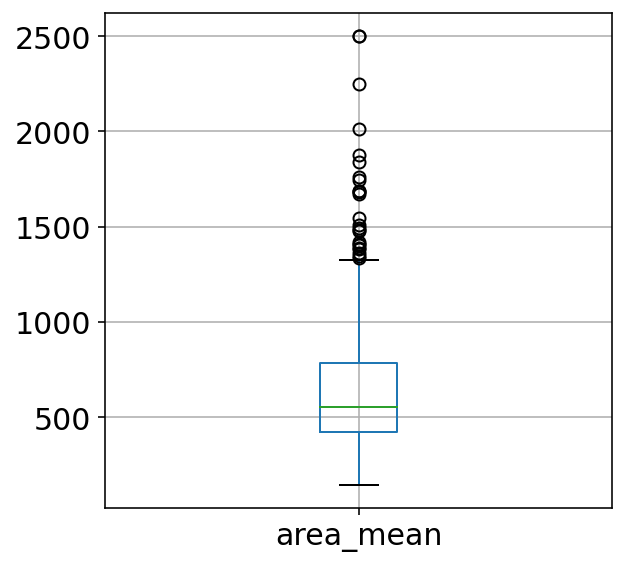

In [303]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('area_mean')
# plt.subplot(2,2,2)
# df.boxplot('area_se')
# plt.subplot(2,2,3)
# df.boxplot('area_worst')

#### Smoothness

<AxesSubplot:>

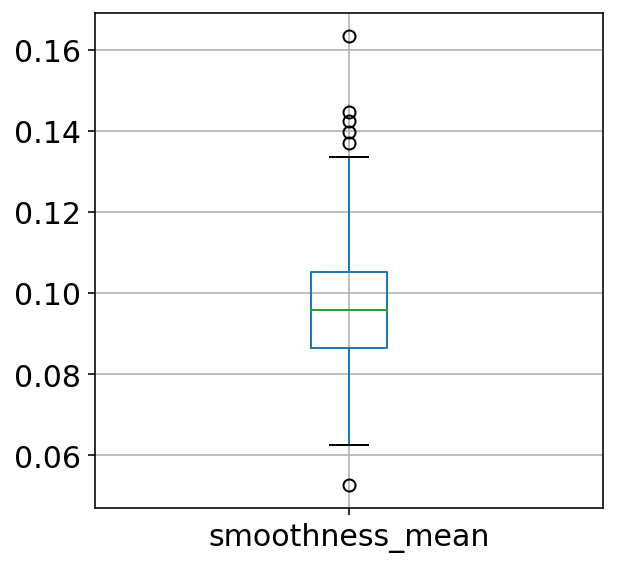

In [304]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('smoothness_mean')
# plt.subplot(2,2,2)
# df.boxplot('smoothness_se')
# plt.subplot(2,2,3)
# df.boxplot('smoothness_worst')

#### Compactness

<AxesSubplot:>

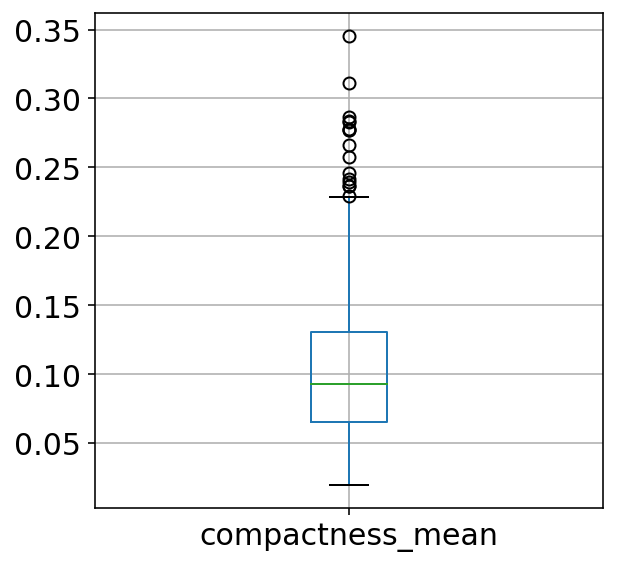

In [305]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('compactness_mean')
# plt.subplot(2,2,2)
# df.boxplot('compactness_se')
# plt.subplot(2,2,3)
# df.boxplot('compactness_worst')

#### Concavity

<AxesSubplot:>

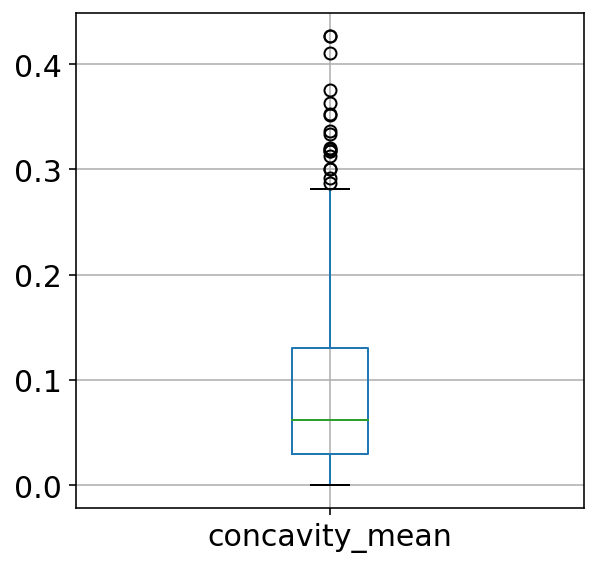

In [306]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('concavity_mean')
# plt.subplot(2,2,2)
# df.boxplot('concavity_se')
# plt.subplot(2,2,3)
# df.boxplot('concavity_worst')

#### Concave points

<AxesSubplot:>

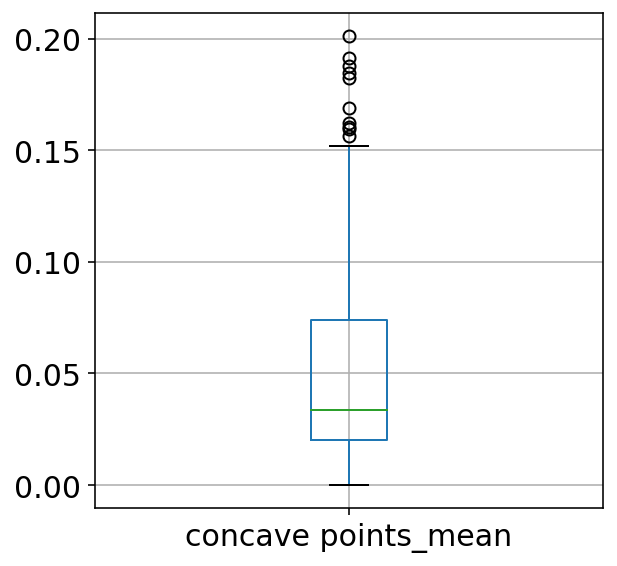

In [307]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('concave points_mean')
# plt.subplot(2,2,2)
# df.boxplot('concave points_se')
# plt.subplot(2,2,3)
# df.boxplot('concave points_worst')

#### Symmetry

<AxesSubplot:>

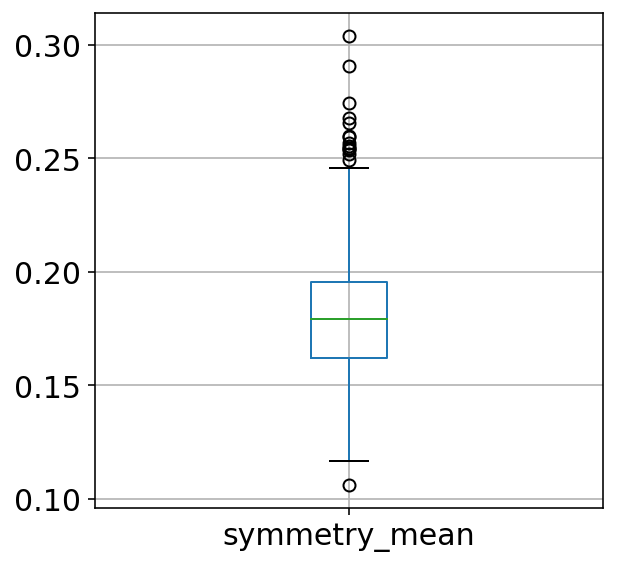

In [308]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('symmetry_mean')
# plt.subplot(2,2,2)
# df.boxplot('symmetry_se')
# plt.subplot(2,2,3)
# df.boxplot('symmetry_worst')

#### Fractal dimension

<AxesSubplot:>

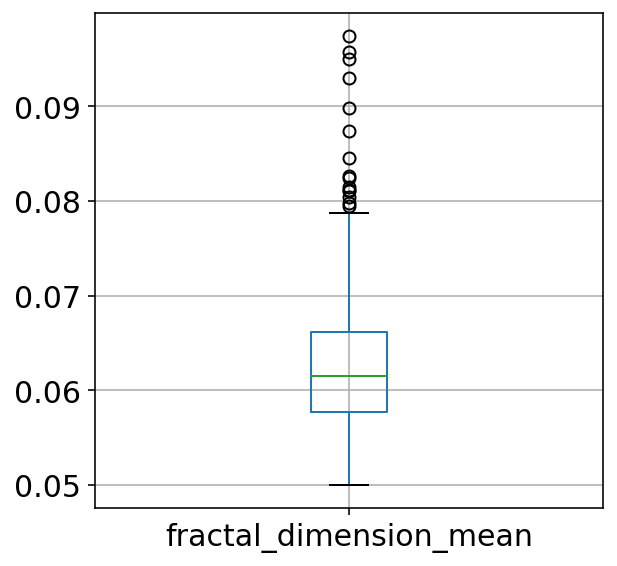

In [309]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('fractal_dimension_mean')
# plt.subplot(2,2,2)
# df.boxplot('fractal_dimension_se')
# plt.subplot(2,2,3)
# df.boxplot('fractal_dimension_worst')

### Preprocess your data according to the data quality plan

In [310]:
# Check how many 0s and 1s are there in the dataset
print('Class 1:', df['diagnosis'].value_counts()[1])
print('Class 0:', df['diagnosis'].value_counts()[0])

Class 1: 357
Class 0: 212


We do not need to do sub_sample since the quantity of target feature is balanced.

## Buliding models

In [311]:
y = df.diagnosis
X = df.drop('diagnosis', axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [312]:
train_sizes = [1, 20, 50, 100, 200, 450]
features = X.columns.tolist()
target = ['diagnosis']

### Random Forest

#### Train and evaluate your model

accuracy score:  0.9415204678362573
f1-score:  0.9532710280373831
recall score:  0.9807692307692307


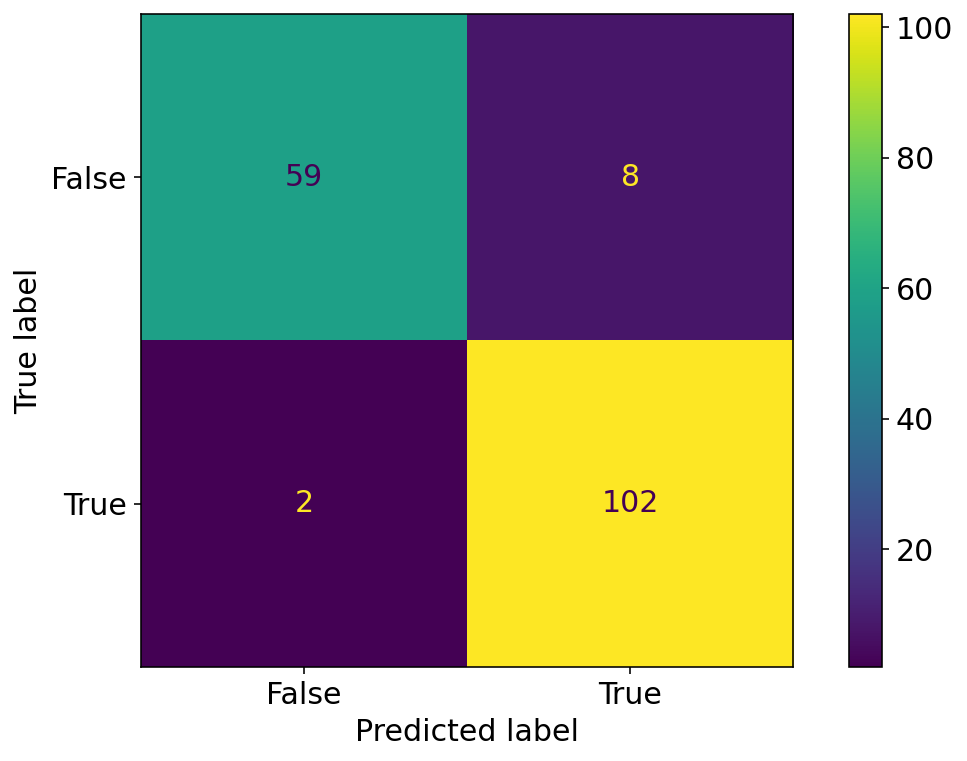

In [338]:
# train model
rfc = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

# Evaluation
print('accuracy score: ', accuracy_score(y_test, rfc_pred))
print('f1-score: ', f1_score(y_test, rfc_pred))
print('recall score: ', recall_score(y_test, rfc_pred))
# print("confusion_matrix:\n",
#               confusion_matrix(y_test, rfc_pred))
confusion_matrix = metrics.confusion_matrix(y_test, rfc_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

#### Calculate the variance and bias

In [339]:
# Get the bias and variance
var = np.var(rfc_pred)
n = len(rfc_pred)
SSE = sum(rfc_pred-np.mean(rfc_pred))**2
MSE = SSE / n
Bias = abs((MSE-var))**(1/2)
print("Variance: ", var)
print("Bias: ", Bias)

Variance:  0.2294723162682535
Bias:  0.4790326880999391


#### Plot the learning curve and analyze it

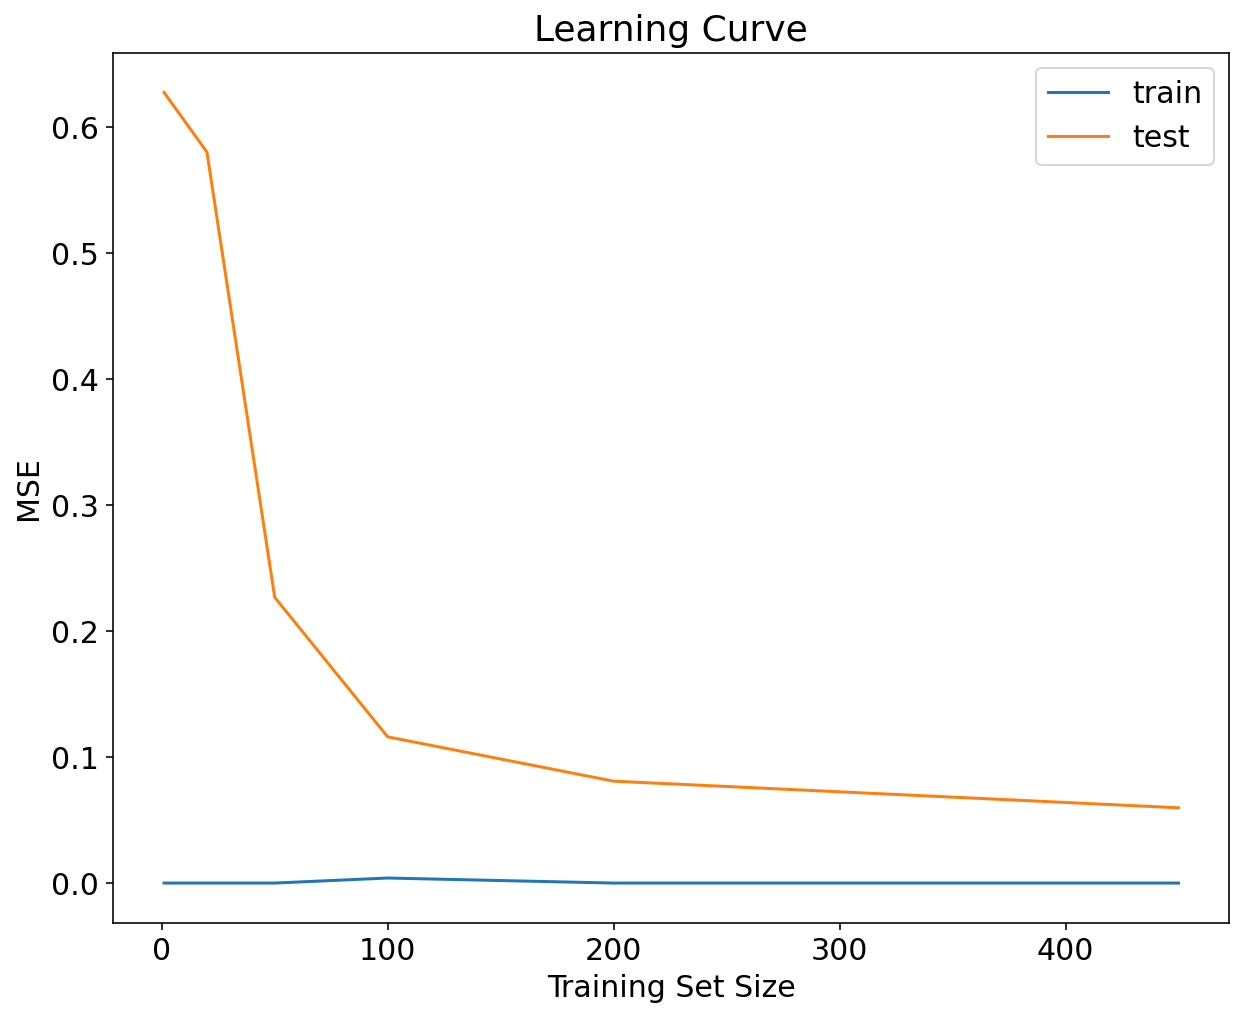

In [340]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator = rfc, X = X, y = y,
    train_sizes = train_sizes,
    scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
test_scores_mean = -test_scores.mean(axis = 1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_scores_mean, label="train")
plt.plot(train_sizes, test_scores_mean, label="test")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.legend(loc="best")

plt.show()

## Feature importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


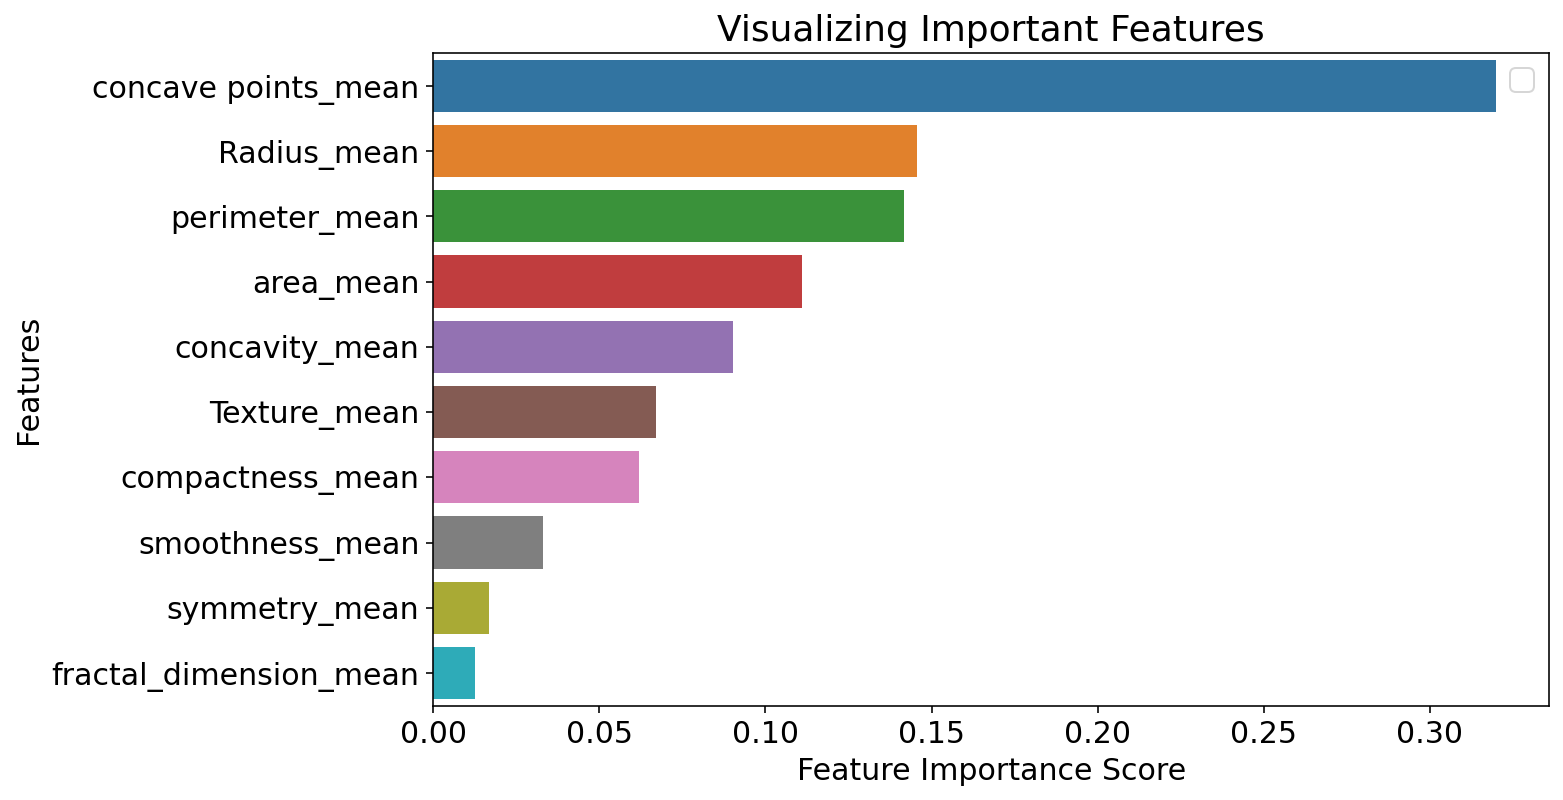

In [341]:
feature_imp = pd.Series(rfc.feature_importances_,index=features).sort_values(ascending=False)
feature_imp
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Feature selection

In [345]:
#Drop variables which score less than 0.05
X_s = df[['concave points_mean','area_mean', 'perimeter_mean', 'concavity_mean','Radius_mean','Texture_mean','compactness_mean']]
Y_s = df.diagnosis
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_s, Y_s, test_size=0.3, random_state=5) # 70% training and 30% test

accuracy score:  0.9532163742690059
f1-score:  0.9629629629629629
recall score:  0.9454545454545454


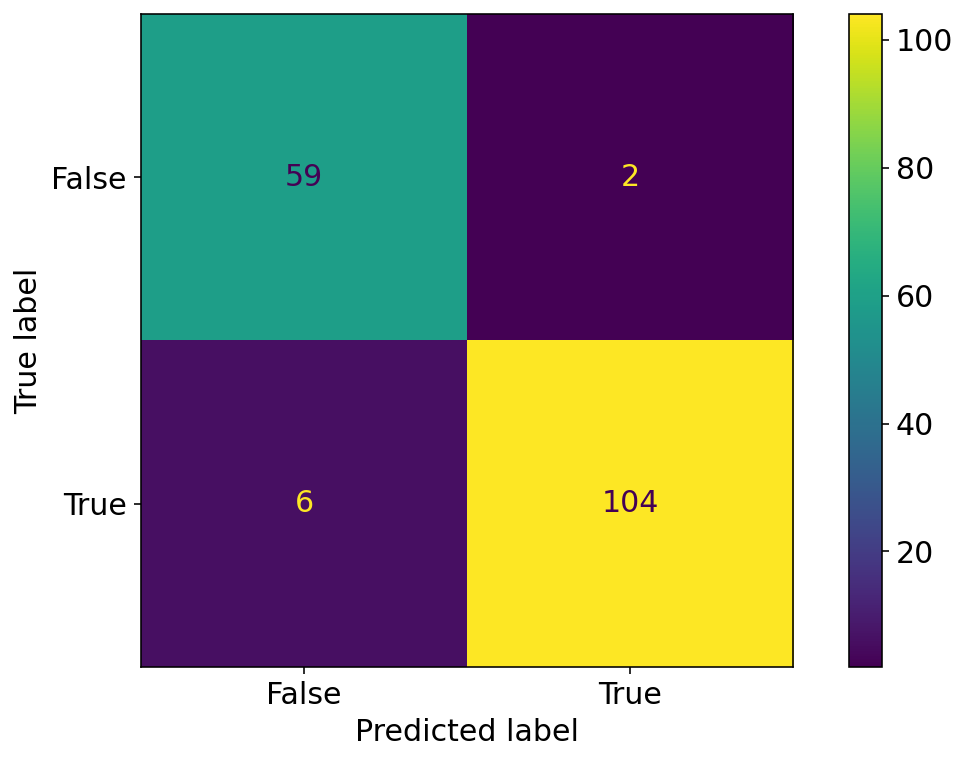

In [346]:
# train model
rfc1 = RandomForestClassifier(n_estimators=30).fit(X_train1, y_train1)

# predict on test set
rfc_pred1 = rfc1.predict(X_test1)

# Evaluation
print('accuracy score: ', accuracy_score(y_test1, rfc_pred1))
print('f1-score: ', f1_score(y_test1, rfc_pred1))
print('recall score: ', recall_score(y_test1, rfc_pred1))
# print("confusion_matrix:\n",
#               confusion_matrix(y_test1, rfc_pred1))
confusion_matrix = metrics.confusion_matrix(y_test1, rfc_pred1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<b>Analysis:</b>

After removing the least important features, the accuracy increased. This is because you removed misleading data and noise, resulting in an increased accuracy. A lesser amount of features also reduces the training time.

## AdaBoost

### Base: decision tree

Accuracy: 0.9473684210526315
recall_score:  0.9903846153846154
f1_score:  0.9581395348837211


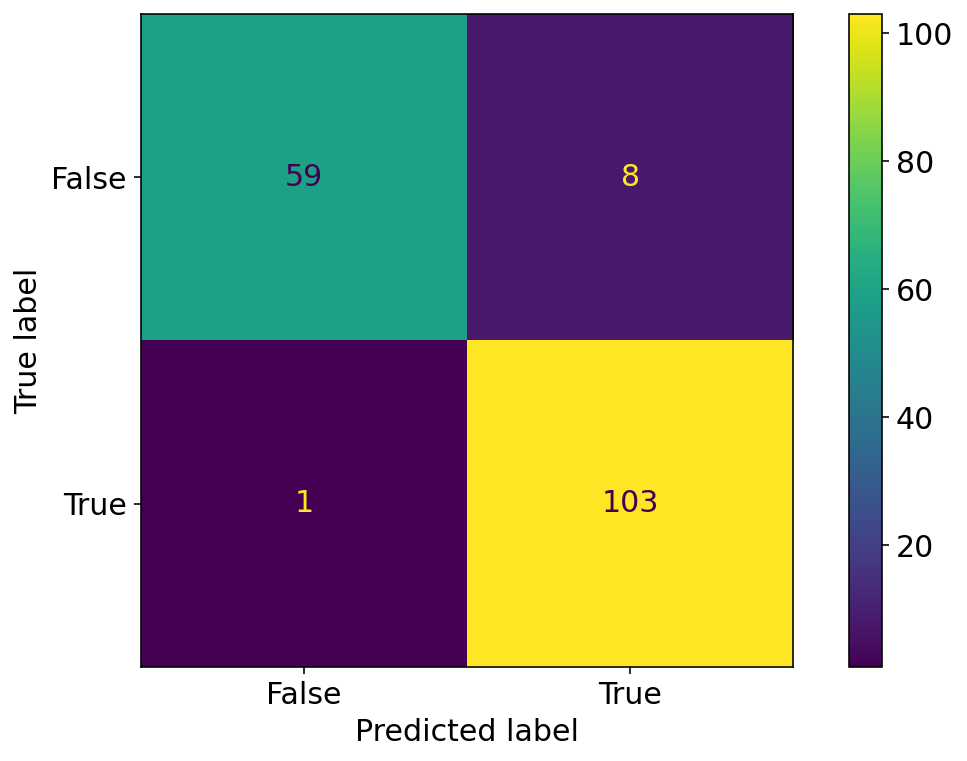

In [344]:
# Train model
abc = AdaBoostClassifier(n_estimators=30, learning_rate=1)

# Fit model
abc_model = abc.fit(X_train, y_train)

# Predict on test set
abc_pred = abc_model.predict(X_test)

# Evaluation
print("Accuracy:",metrics.accuracy_score(y_test, abc_pred))
print("recall_score: ", recall_score(y_test, abc_pred))
print("f1_score: ", f1_score(y_test, abc_pred))
# print("confusion_matrix:\n",
#               confusion_matrix(y_test1, abc_pred))

confusion_matrix = metrics.confusion_matrix(y_test, abc_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### Base: Support Vector Classifier

Accuracy: 0.9005847953216374
recall_score:  0.9807692307692307
f1_score:  0.9230769230769229


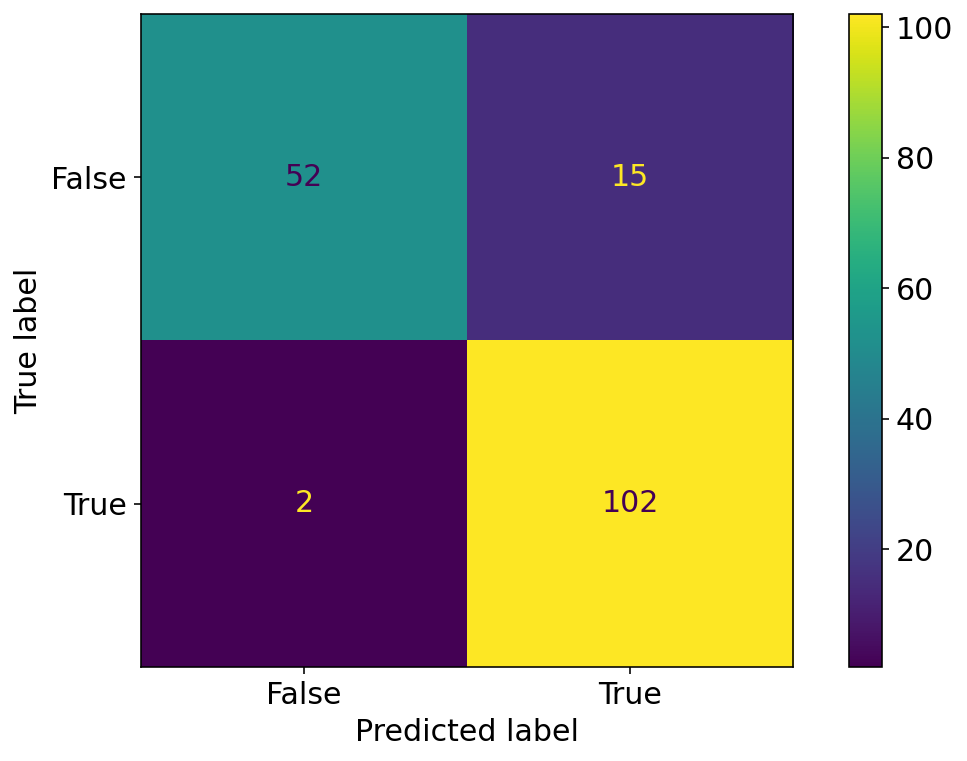

In [348]:
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc_1 =AdaBoostClassifier(n_estimators=30, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model_1 = abc_1.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_1 = model_1.predict(X_test)

# Evaluation
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_1))
print("recall_score: ", recall_score(y_test, y_pred_1))
print("f1_score: ", f1_score(y_test, y_pred_1))
#print("confusion_matrix:\n", confusion_matrix(y_test1, y_pred_1))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


Comparing SVC with decision tree, the accuracy ratio of SVC is decrease and recall_score is decrease.
Therefore, using adaboost with decision tree is best.

#### Calculate the variance and bias

In [349]:

# Get the bias and variance with decision tree
var = np.var(abc_pred)
n = len(abc_pred)
SSE = sum(abc_pred-np.mean(abc_pred))**2
MSE = SSE / n
Bias = abs((MSE-var))**(1/2)
print("Variance: ", var)
print("Bias: ", Bias)

Variance:  0.22776238842720836
Bias:  0.4772445792538752


#### Plot the learning curve and analyze it

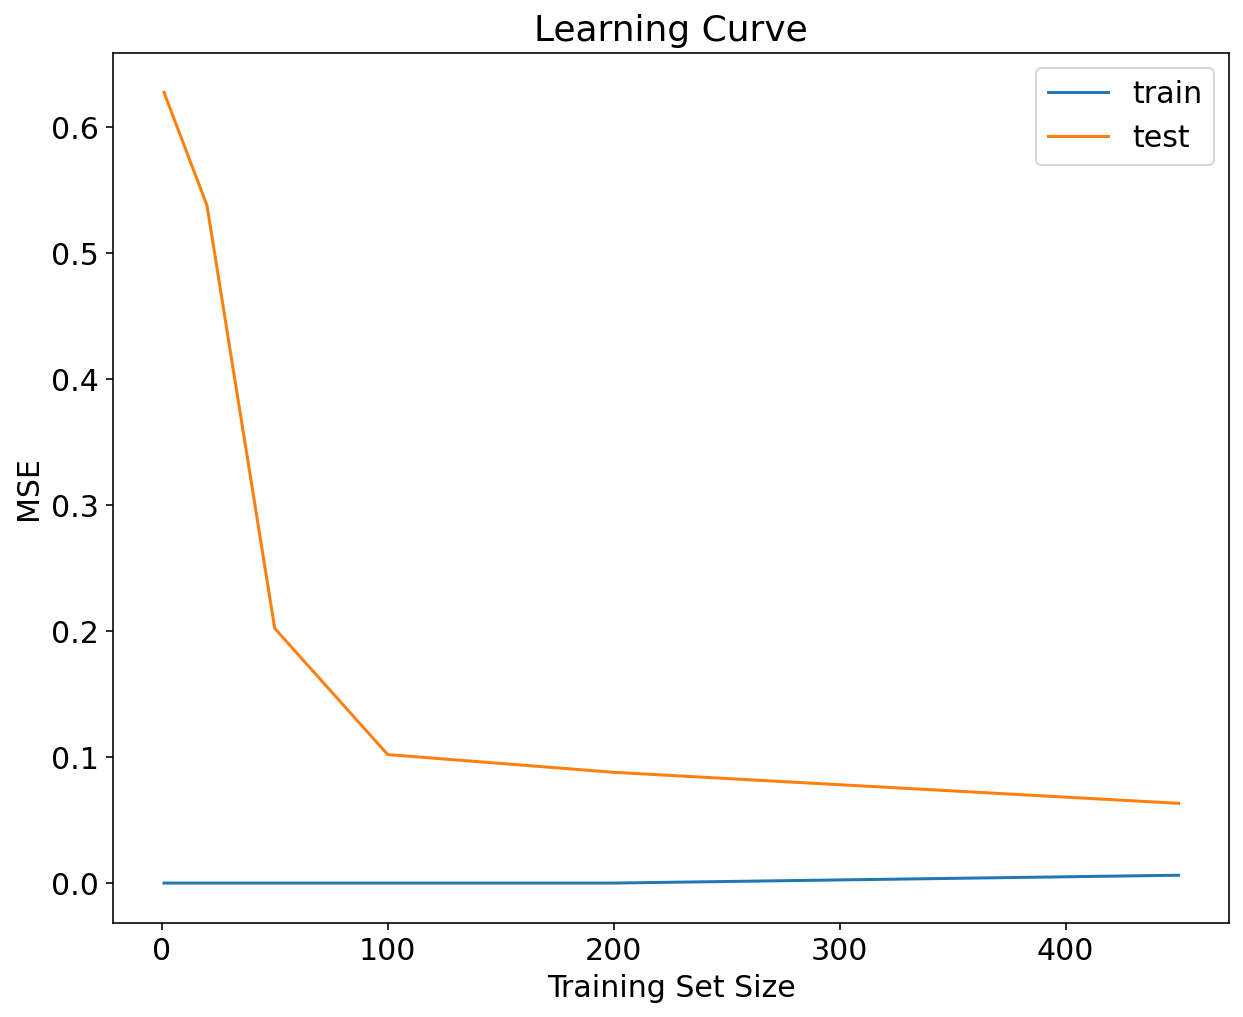

In [350]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator = abc, X = X, y = y,
    train_sizes = train_sizes,
    scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
test_scores_mean = -test_scores.mean(axis = 1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_scores_mean, label="train")
plt.plot(train_sizes, test_scores_mean, label="test")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.legend(loc="best")

plt.show()

<b>Analysis:</b>
 
 分析learning curve

## Model comparison

### Analyze the bias and variance of the models

## References:
[1]. https://www.analyticsvidhya.com/blog/2021/06/adaboost-a-brief-introduction-to-ensemble-learning/#:~:text=Coming%20to%20the%20advantages%2C%20Adaboost,rather%20than%20binary%20classification%20problems

[2]. https://towardsdatascience.com/building-a-random-forest-classifier-for-neural-spike-data-8e523f3639e1

[3]. https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/


